In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading data

In [18]:
df_full = pd.read_csv('heart_full.csv')
df_test = pd.read_csv('heart_4_test.csv')
df_train = pd.read_csv('heart_4_train.csv')
df = pd.concat([df_test, df_train])

# Analyze

### Analyzing numeric atributes

               age  systolic_pressure  diastolic_pressure  daily_cigarettes  \
count  4240.000000        4240.000000         4240.000000       4217.000000   
mean     51.572832         132.354599           82.897759          9.005856   
std      14.198549          22.033300           11.910394         11.913975   
min      32.000000          83.500000           48.000000          0.000000   
25%      42.000000         117.000000           75.000000          0.000000   
50%      49.000000         128.000000           82.000000          0.000000   
75%      57.000000         144.000000           90.000000         20.000000   
max     134.797486         295.000000          142.500000         70.000000   

       cholesterol_level   heart_rate   mass_index  blood_sugar_level  \
count        3878.000000  4239.000000  4222.000000        3919.000000   
mean          236.618222    75.878981    25.800776          81.963664   
std            43.481077    12.025348     4.079357          23.748635

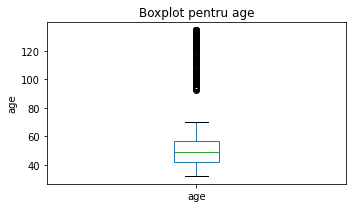

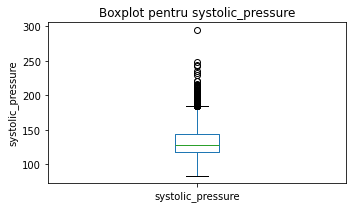

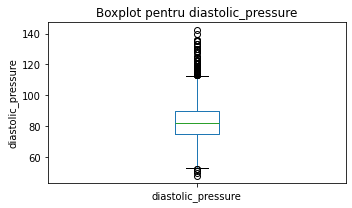

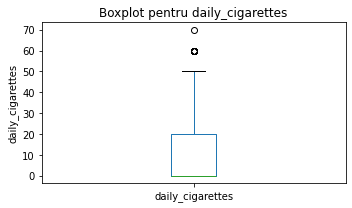

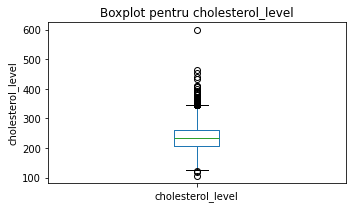

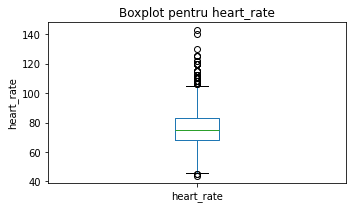

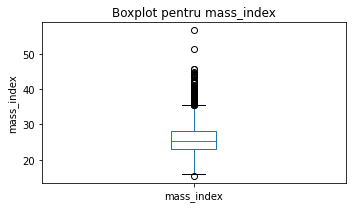

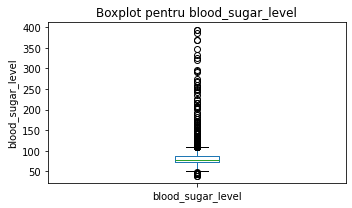

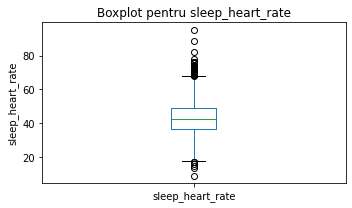

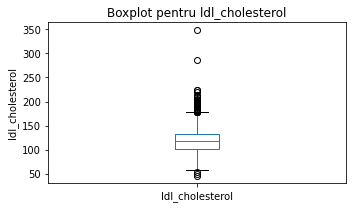

In [19]:
numeric_cols = [
    'age', 'systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
    'cholesterol_level', 'heart_rate', 'mass_index',
    'blood_sugar_level', 'sleep_heart_rate', 'ldl_cholesterol'
]

numeric_data = df[numeric_cols].describe()
print(numeric_data)

for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    df.boxplot(column=col)
    plt.title(f'Boxplot pentru {col}')
    plt.ylabel(col)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

### Analyzing discret/ordinary atributes

In [20]:
discret__ordinary_cols = [
    'gender', 'education_level', 'blood_pressure_medication',
    'smoking_status', 'hypertension_history', 'stroke_history',
    'diabetes_history', 'high_blood_sugar'
]

print(f"Number of example with no NaN values: {len(df[discret__ordinary_cols].dropna())}\n")

nunique_vals = df[discret__ordinary_cols].nunique()
print(f"Number of unique values:\n{nunique_vals}")

Number of example with no NaN values: 3783

Number of unique values:
gender                       2
education_level              4
blood_pressure_medication    2
smoking_status               2
hypertension_history         2
stroke_history               2
diabetes_history             2
high_blood_sugar             2
dtype: int64


### Analyzing balance of classes

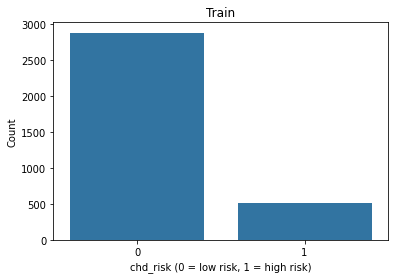

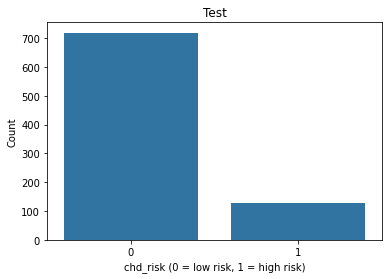

In [21]:
import seaborn as sns

sns.countplot(x='chd_risk', data=df_train)
plt.title('Train')
plt.xlabel('chd_risk (0 = low risk, 1 = high risk)')
plt.ylabel('Count')
plt.show()

sns.countplot(x='chd_risk', data=df_test)
plt.title('Test')
plt.xlabel('chd_risk (0 = low risk, 1 = high risk)')
plt.ylabel('Count')
plt.show()


### Analyzing corelation between atributes

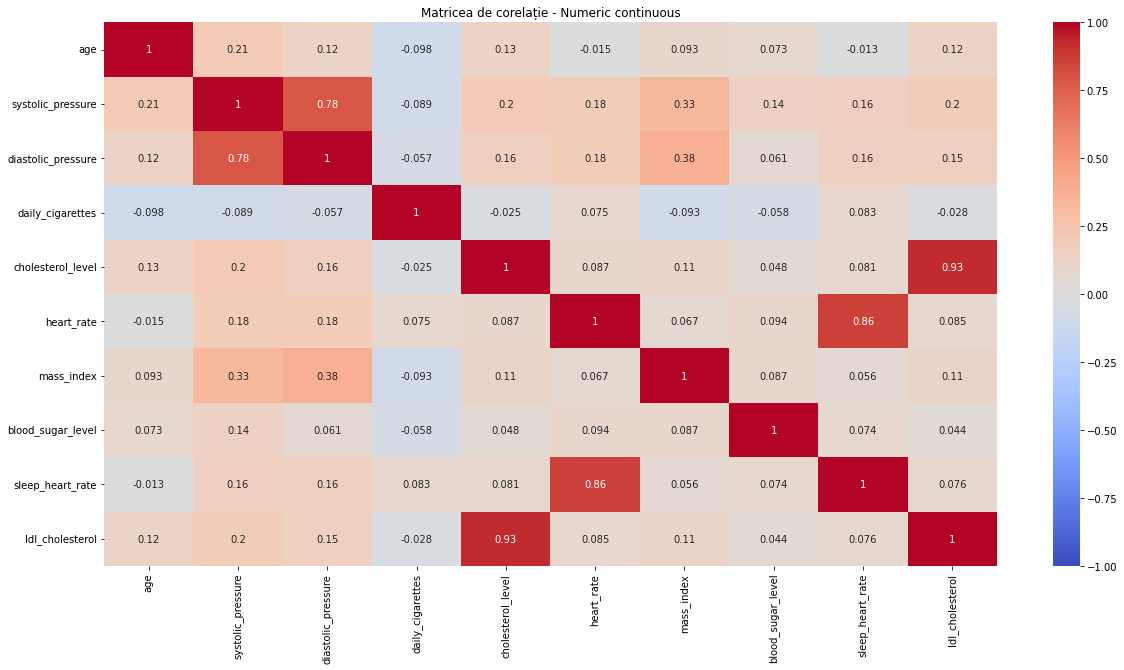

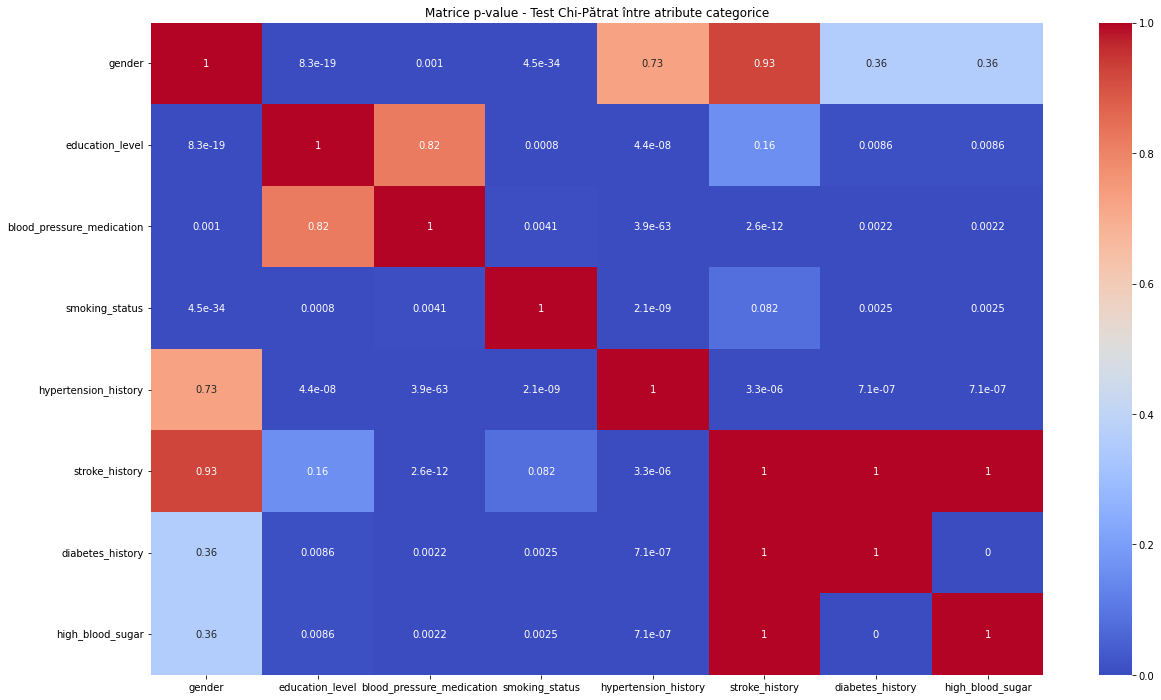

In [22]:
# Between numerical atributes
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matricea de corelație - Numeric continuous')
plt.xticks(rotation=90)
plt.show()

# Between categorical atributes
from scipy.stats import chi2_contingency
categorical_cols = [
    'gender', 'education_level', 'blood_pressure_medication',
    'smoking_status', 'hypertension_history', 'stroke_history',
    'diabetes_history', 'high_blood_sugar'
]

# Creează o matrice pătrată cu NaN inițial
pval_matrix = pd.DataFrame(np.ones((len(categorical_cols), len(categorical_cols))),
                          index=categorical_cols, columns=categorical_cols)

for i in range(len(categorical_cols)):
    for j in range(i+1, len(categorical_cols)):
        col1 = categorical_cols[i]
        col2 = categorical_cols[j]
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

# Pe diagonală pune 0 (p=0, perfect corelate cu ele însele)
np.fill_diagonal(pval_matrix.values, 1)

plt.figure(figsize=(20, 12))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Matrice p-value - Test Chi-Pătrat între atribute categorice')
plt.show()

# Preprocesing

Dropping corelated atributes and printing atributes with missing data

In [23]:
# df_copy = pd.read_csv('heart_4_train.csv')
# df.drop(columns=['ldl_cholesterol', 'sleep_heart_rate'], inplace=True)

missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))


Atribute cu valori lipsă: ['blood_pressure_medication', 'cholesterol_level', 'daily_cigarettes', 'heart_rate', 'smoking_status', 'mass_index', 'blood_sugar_level', 'education_level', 'sleep_heart_rate', 'ldl_cholesterol']


### Imputation of missing values

In [24]:
from sklearn.impute import SimpleImputer

# For blood_pressure_medication
imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)
df[['blood_pressure_medication']] = imputer.fit_transform(df[['blood_pressure_medication']])

In [25]:
# For daily_cigarettes
imputer = SimpleImputer(strategy='constant', missing_values=pd.NA, fill_value=0)
df[['daily_cigarettes']] = imputer.fit_transform(df[['daily_cigarettes']])

362


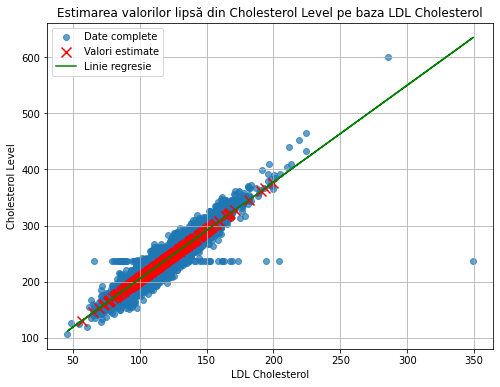

37
0


In [26]:
# For cholesterol level
from sklearn.linear_model import LinearRegression
df_nonan = df[['cholesterol_level', 'ldl_cholesterol']].dropna()

print(df['cholesterol_level'].isnull().sum())
X_train = df_nonan[['ldl_cholesterol']]
y_train = df_nonan['cholesterol_level']

# Antrenăm modelul de regresie liniară
model = LinearRegression()
model.fit(X_train, y_train)

# Găsim rândurile unde cholesterol_level lipsește, dar ldl_cholesterol există
missing_cholesterol = df['cholesterol_level'].isna() & df['ldl_cholesterol'].notna()

# Prezicem valorile lipsă
predicted_values = model.predict(df.loc[missing_cholesterol, ['ldl_cholesterol']])
df.loc[missing_cholesterol, 'cholesterol_level'] = predicted_values

# Grafic: punctele originale și cele completate
plt.figure(figsize=(8,6))
plt.scatter(df_nonan['ldl_cholesterol'], df_nonan['cholesterol_level'], label='Date complete', alpha=0.7)
plt.scatter(df.loc[missing_cholesterol, 'ldl_cholesterol'], predicted_values, color='red', label='Valori estimate', marker='x', s=100)
plt.plot(df_nonan['ldl_cholesterol'], model.predict(X_train), color='green', label='Linie regresie')
plt.xlabel('LDL Cholesterol')
plt.ylabel('Cholesterol Level')
plt.title('Estimarea valorilor lipsă din Cholesterol Level pe baza LDL Cholesterol')
plt.legend()
plt.grid(True)
plt.show()

print(df['cholesterol_level'].isnull().sum())

imputer = SimpleImputer(strategy='median', missing_values=pd.NA)
df[['cholesterol_level']] = imputer.fit_transform(df[['cholesterol_level']])
print(df['cholesterol_level'].isnull().sum())


In [27]:
# For heart rate
print(df['heart_rate'].isnull().sum())
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df[['heart_rate', 'sleep_heart_rate']] = imputer.fit_transform(df[['heart_rate', 'sleep_heart_rate']])
print(df['heart_rate'].isnull().sum())


1
0


In [28]:
# For mass_index
print(df['mass_index'].isnull().sum())

imputer = SimpleImputer(strategy='mean')
df['mass_index'] = imputer.fit_transform(df[['mass_index']])
print(df['mass_index'].isnull().sum())


18
0


In [29]:
# For blood sugar level
print(df['blood_sugar_level'].isnull().sum())

imputer = SimpleImputer(strategy='mean')
df['blood_sugar_level'] = imputer.fit_transform(df[['blood_sugar_level']])
print(df['blood_sugar_level'].isnull().sum())

321
0


### Reduntant atributes


In [30]:
df.drop(columns=['ldl_cholesterol', 'sleep_heart_rate', 'education_level', 'smoking_status'], inplace=True)
categorical_cols = [col for col in categorical_cols if col not in ['education_level', 'smoking_status']]
missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))

Atribute cu valori lipsă: []


### remove of extreme values

In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np

cols = ['systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
        'cholesterol_level', 'heart_rate', 'mass_index', 'blood_sugar_level']

imputer = SimpleImputer(strategy='mean')
df_copy = df[cols].copy()
plt.figure(figsize=(14, len(cols)*5))  # înălțime variabilă după număr coloane

for i, col in enumerate(cols):
    # Detectare IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Pregătim subplot pentru coloana curentă - 2 coloane (înainte și după)
    plt.subplot(len(cols), 2, 2*i + 1)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6)
    plt.title(f'{col} - înainte de imputare')
    plt.xlabel('Index eșantion')
    plt.ylabel(col)
    plt.ylim(0, 1.1 * df_copy[col].max())  # scale uniformă aproximativ

    # Setăm valorile extreme ca NaN în copia pentru imputare
    mask_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[mask_outliers, col] = np.nan

    # Imputăm valorile lipsă (inclusiv extremele)
    df[col] = imputer.fit_transform(df[[col]])

    plt.subplot(len(cols), 2, 2*i + 2)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6, color='orange')
    plt.title(f'{col} - după imputare')
    plt.xlabel('Index eșantion')
    plt.ylim(0, 1.1 * df_copy[col].max())

plt.tight_layout()
plt.show()


### Standardization

In [32]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['systolic_pressure', 'diastolic_pressure', 'daily_cigarettes',
                'cholesterol_level', 'heart_rate', 'mass_index', 'blood_sugar_level']

scaler = StandardScaler()

# Extragem doar coloanele numerice
X_numeric = df[numeric_cols]

# Aplicăm scalarea
X_scaled = scaler.fit_transform(X_numeric)

# Dacă vrei să păstrezi într-un DataFrame cu aceleași nume de coloane:
df[numeric_cols] = X_scaled

# Verificăm media și deviația standard după scalare
print(f'Media pe coloane după scalare:\n{df[numeric_cols].mean(axis=0)}\n')
print(f'Deviația standard pe coloane după scalare:\n{df[numeric_cols].std(axis=0)}\n')


Media pe coloane după scalare:
systolic_pressure    -3.686778e-17
diastolic_pressure    6.703233e-18
daily_cigarettes     -5.865329e-17
cholesterol_level    -2.966181e-16
heart_rate            1.332268e-16
mass_index            4.859844e-17
blood_sugar_level    -2.664535e-16
dtype: float64

Deviația standard pe coloane după scalare:
systolic_pressure     1.000118
diastolic_pressure    1.000118
daily_cigarettes      1.000118
cholesterol_level     1.000118
heart_rate            1.000118
mass_index            1.000118
blood_sugar_level     1.000118
dtype: float64



### Encoding categorical variables

In [18]:
# df = pd.get_dummies(df, columns=categorical_cols, dtype=float, drop_first=False)
print(df)

      blood_pressure_medication  cholesterol_level  stroke_history  \
0                           0.0       2.300606e+00               0   
1                           0.0       3.414921e-02               0   
2                           0.0      -1.240430e+00               0   
3                           0.0      -5.016526e-01               0   
4                           0.0       1.791105e+00               0   
...                         ...                ...             ...   
3387                        0.0      -1.138530e+00               0   
3388                        0.0      -1.520656e+00               0   
3389                        0.0      -8.073536e-01               0   
3390                        0.0       1.358028e+00               0   
3391                        0.0       7.240454e-16               0   

      systolic_pressure  hypertension_history  daily_cigarettes  \
0             -0.611905                     0         -0.761283   
1             -0.882535  

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # or RandomForestClassifier
from sklearn.model_selection import train_test_split
target_col = 'chd_risk'
model = DecisionTreeClassifier(class_weight='balanced', random_state=123)
X = df.drop(columns=[target_col])  # variabilele de intrare
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  # or 'accuracy', 'recall_macro', etc.
    n_jobs=-1,  # use all CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1}
Best Score (CV): 0.5604610255704777


## Decision TREE

chd_risk
0    0.848113
1    0.151887
Name: proportion, dtype: float64
Confusion Matrix:
[[522 190]
 [ 84  52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       712
           1       0.21      0.38      0.28       136

    accuracy                           0.68       848
   macro avg       0.54      0.56      0.53       848
weighted avg       0.76      0.68      0.71       848


Accuracy: 0.6769


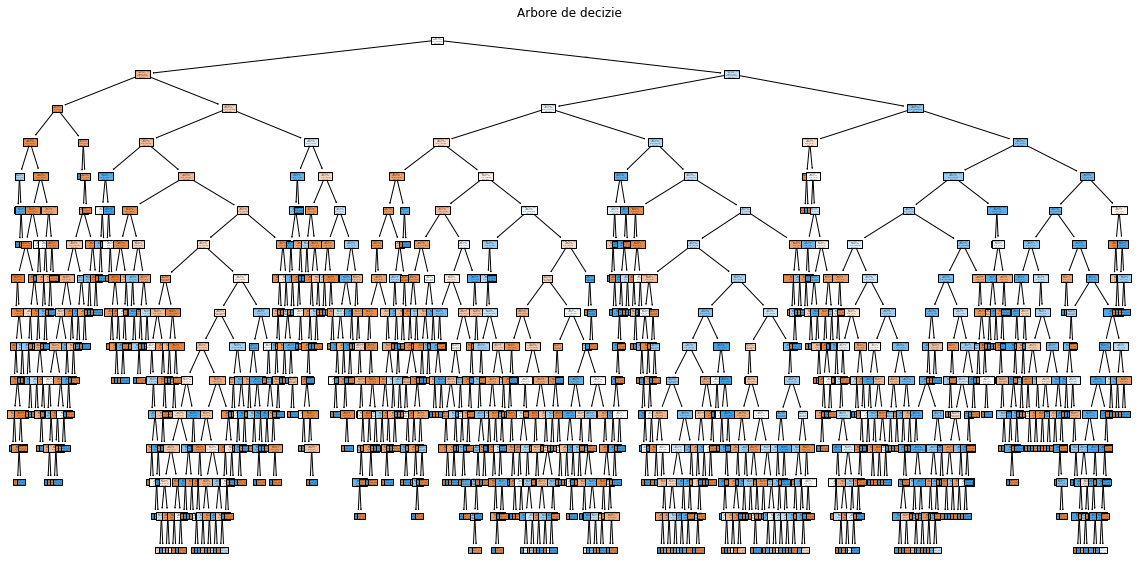

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

target_col = 'chd_risk'  # înlocuiește cu numele real
print(df[target_col].value_counts(normalize=True))  # Proporții

X = df.drop(columns=[target_col])  # variabilele de intrare
y = df[target_col]                 # eticheta

# Împărțim în set de antrenare și test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
clf = DecisionTreeClassifier(criterion='gini', max_depth= 15, min_samples_leaf=1, random_state=123)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=True, filled=True)
plt.title("Arbore de decizie")
plt.show()


## Random Forest


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Presupunem că datele sunt deja în DataFrame-ul df
X = df.drop('chd_risk', axis=1)
y = df['chd_risk']

# Împărțire train/test cu stratificare (păstrează proporțiile claselor)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Aplicare SMOTE pe setul de antrenament (echilibrare clase)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Antrenare Random Forest pe datele echilibrate
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)

# Predicții pe setul de test
y_pred = model.predict(X_test)

# Evaluare
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[639  80]
 [ 99  30]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8659    0.8887    0.8771       719
           1     0.2727    0.2326    0.2510       129

    accuracy                         0.7889       848
   macro avg     0.5693    0.5606    0.5641       848
weighted avg     0.7756    0.7889    0.7819       848



## Multi-Layered perceptron


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Selectarea caracteristicilor și a etichetei țintă
X = df.drop('chd_risk', axis=1)
y = df['chd_risk']

# Împărțire date în train/test cu stratificare
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

# Standardizare (necesară pentru MLP!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Echilibrare cu SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# Antrenare model MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_res, y_res)

# Predicții
y_pred = mlp.predict(X_test_scaled)

# Evaluare
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[577 142]
 [ 76  53]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8836    0.8025    0.8411       719
           1     0.2718    0.4109    0.3272       129

    accuracy                         0.7429       848
   macro avg     0.5777    0.6067    0.5841       848
weighted avg     0.7905    0.7429    0.7629       848



/home/enciu/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
